# **Advanced DL and RL: Домашнее задание 2**


## **Выполнил: Русаков Д.Д.**
## **Группа: MADE-DS-32**

#Для улучшения точности и сравнения методов необходимо данные решения дообучить на большем количестве итераций. Из-за ограничения по времени и наличию вычислительных мощностей (или их стабильной работы) обучение полностью не проводилось.

In [1]:
!pip install gym

In [2]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
import tqdm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

In [ ]:
from TicTacToe import TicTacToe
from TicTacToeDQN import TicTacToeDQN
from TicTacToeDoubleDQN import TicTacToeDoubleDQN
from MCTS import MCTS, Node

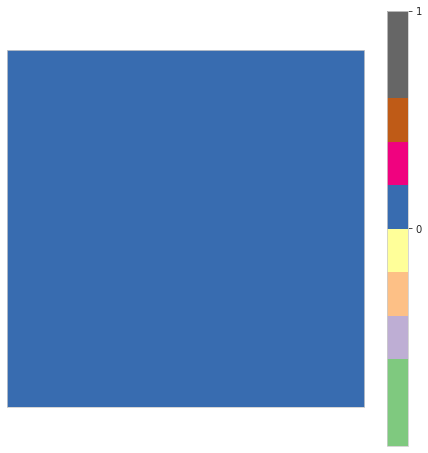

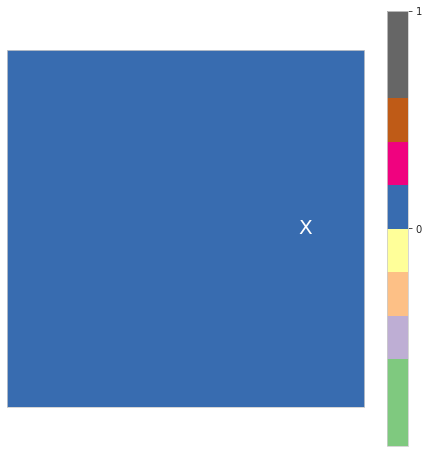

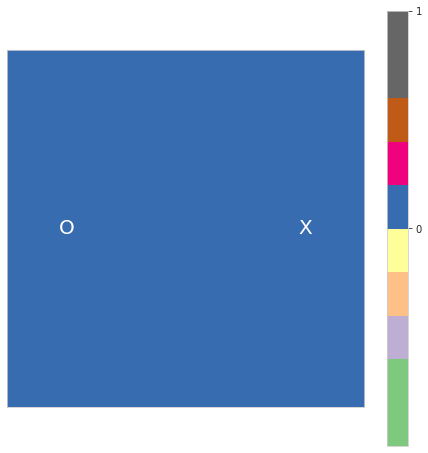

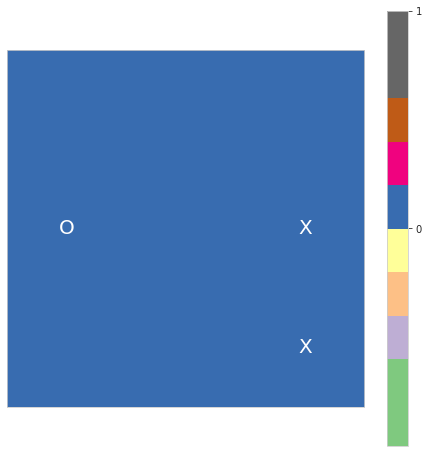

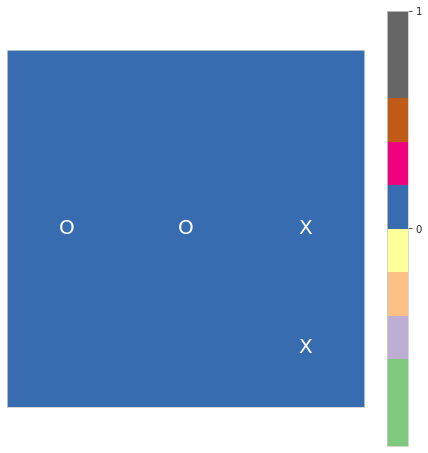

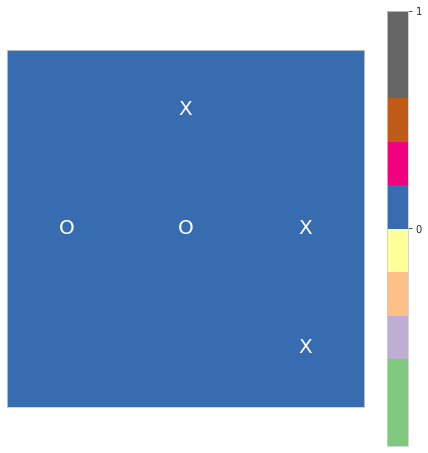

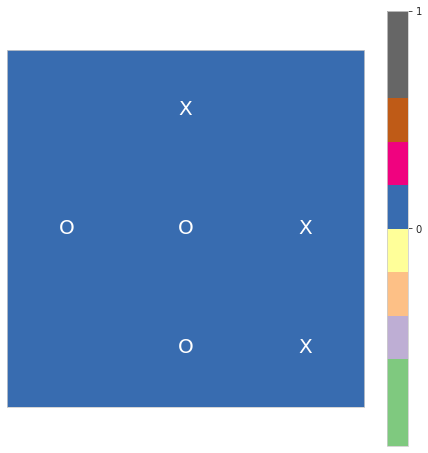

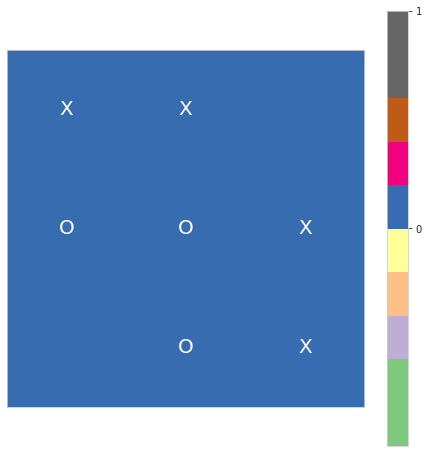

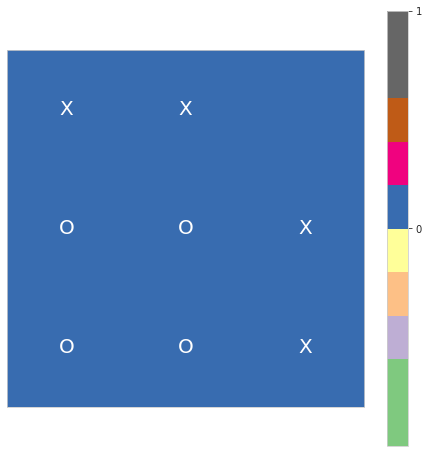

Крестики выиграли!


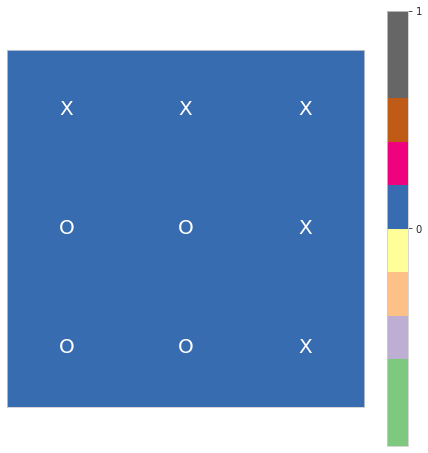

In [ ]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
plot_test_game(env, None, None, random_1=True, random_2=True, verbose=True, fontx=20)

###**Часть первая:** 

Крестики-нолики при помощи Q-обучения
В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.
1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.


In [4]:
class R_Agent(object):
    def __init__(self):
        self.index_best_action = True
        pass

    def get_best_action(self, state, n_actions=None):
        if n_actions is None:
            n_actions = np.sum(np.array(list(state)) == '1')
        return np.random.randint(n_actions)

In [5]:
class QL_Agent:
    def __init__(self, alpha=0.009, epsilon=0.1, gamma=1.0):
        self.index_best_action = True

        self.Q = {}
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        
    
    def Q_action(self, state, n_actions=None):
        if state not in self.Q:
            if n_actions is None:
                n_actions = np.sum(np.array(list(state)) == '1')
            self.Q[state] = np.random.random(n_actions) * 0.01 - 0.005
        return self.Q[state]
  
    def update_Q(self, state, n_action, reward, next_state):
        Q = self.Q_action(state)[n_action]
        if next_state is None:
            V = 0
        else:
            V = self.get_V(next_state)
            
        self.Q[state][n_action] = Q + self.alpha * (reward + self.gamma * V - Q)

    def get_V(self, state):
        return np.max(self.Q_action(state))

    def get_best_action(self, state, n_actions=None):
        return np.argmax(self.Q_action(state, n_actions))

    # epsilon-greedy action
    def select_action(self, state, epsilon, n_actions=None):
        if np.random.random() > epsilon:
            return self.get_best_action(state, n_actions)
        else:
            if n_actions is None:
                n_actions = np.sum(np.array(list(state)) == '1')
            return np.random.randint(n_actions)


In [6]:
def test_game(env, pi_1, pi_2, num_games=1000):
    w1 = 0
    w2 = 0
    for _ in range(num_games):
        reward = play_game(env, pi_1, pi_2)
        if reward == 1:
            w1 += 1
        elif reward == -1:
            w2 += 1
    return w1 / num_games, w2 / num_games

In [7]:
def play_game(env, pi_1, pi_2):
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        n_actions = len(actions)
        if env.curTurn == 1:
            if pi_1.index_best_action:
                a = actions[pi_1.get_best_action(s, n_actions)]
            else:
                a = pi_1.get_best_action(s)
        else:
            if pi_2.index_best_action:
                a = actions[pi_2.get_best_action(inv_state(s), n_actions)]
            else:
                a = pi_2.get_best_action(inv_state(s))
        observation, reward, done, info = env.step(a)
        if reward < -1:
            print("Ход в занятую клетку")
    return reward

def inv_state(s):
    return ''.join([str(2 - int(n)) for n in s])

In [8]:
def QL_train(env, QL_agent,R, max_epsilon, epochs):
    hist_1 = []
    hist_2 = []
    for e in range(epochs):
        
        epsilon = max_epsilon * (epochs - e) / epochs

        if e % (epochs // 5) == 0:
            p, _ = test_game(env, QL_agent, R)
            hist_1.append((e, p))
            _, p = test_game(env, R, QL_agent)
            hist_2.append((e, p))
            
        done = False
        env.reset()

        state_0, actions_0 = env.getHash(), env.getEmptySpaces()
        n_action_0 = QL_agent.select_action(state_0, epsilon, len(actions_0))
        observation, reward, done, info = env.step(actions_0[n_action_0])
        state_1, actions_1 = observation[0], observation[1]
        curTurn = env.curTurn
        state_1 = inv_state(state_1)
        while not done:
            n_action_1 = QL_agent.select_action(state_1, epsilon, len(actions_1))
            observation, reward, done, info = env.step(actions_1[n_action_1])
            if done: 
                QL_agent.update_Q(state_0, n_action_0, -reward * curTurn, None)
                QL_agent.update_Q(state_1, n_action_1, reward * curTurn, None)
                break

            next_state = observation[0]
            curTurn = env.curTurn
            if curTurn == -1:
                next_state = inv_state(next_state)
                
            QL_agent.update_Q(state_0, n_action_0, reward, next_state)
            state_0, actions_0 = state_1, actions_1
            state_1, actions_1 = next_state, observation[1]
            n_action_0 = n_action_1
            
    return hist_1, hist_2

In [ ]:
env= TicTacToe(n_rows=3, n_cols=3, n_win=3)
alpha = 0.009
gamma = 1.0
epsilon =0.1
QL = QL_Agent(alpha,epsilon, gamma)
R = R_Agent()
epochs = 100000
hist_1, hist_2 = QL_train(env, QL,R,epsilon,epochs)

In [10]:
def plot_results(hist_1, hist_2):
    steps = [x[0] for x in hist_1]
    rewards_1 = [x[1] for x in hist_1]
    rewards_2 = [x[1] for x in hist_2]
    plt.plot(steps, rewards_1)
    plt.plot(steps, rewards_2)
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("% reward")
    plt.title("Players Vs Random")
    plt.grid()
    plt.show()
   

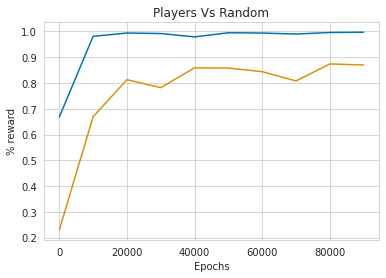

In [12]:
plot_results(hist_1, hist_2)

2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

In [ ]:
env= TicTacToe(n_rows=4, n_cols=4, n_win=4)
alpha = 0.009
gamma = 1.0
epsilon =0.1
QL = QL_Agent(alpha,epsilon, gamma)
R = R_Agent()
epochs = 100000
hist_1, hist_2 = QL_train(env, QL,R,epsilon,epochs)


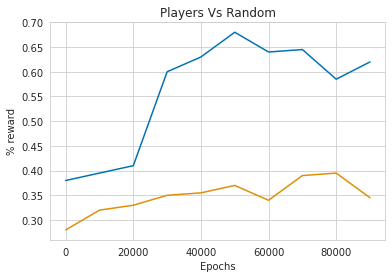

In [14]:
plot_results(hist_1, hist_2)

###**Часть вторая: добавим нейронных сетей**




Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).
3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.


In [15]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)


In [16]:
class Network_3x3(nn.Module):
    def __init__(self, conv_out=128):
        nn.Module.__init__(self)
        self.c1 = nn.Conv2d(3, conv_out * 2, (3, 3))
        self.l1 = nn.Linear(conv_out * 2, conv_out)
        self.l2 = nn.Linear(conv_out, 9)

    def forward(self, x):
        x = F.relu(self.c1(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

In [17]:
def s_to_tensor(s):
    s = np.array([int(c) for c in s])
    size = int(np.sqrt(len(s)))
    pi_1 = np.where(s==2, 1, 0).reshape(size, size)
    pi_2 = np.where(s==0, 1, 0).reshape(size, size)
    empty_spaces = np.where(s==1, 1, 0).reshape(size, size)
    return torch.Tensor(np.stack([pi_1, pi_2, empty_spaces])).reshape(3, size, size)

In [18]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

In [19]:
def DQN_train(DQN, total_episodes, test_episodes):
    hist_1 = []
    hist_2 = []

    for i in tqdm.tqdm(range(1, total_episodes + 1)):
        DQN.run_episode(do_learning=True)
        if i % 1000 == 0:
            pi_1 = DQN.test_strategy(1, test_episodes)
            pi_2 = DQN.test_strategy(-1, test_episodes)
            hist_1.append(np.sum(pi_1==1)/1000)
            hist_2.append(np.sum(pi_2==1)/1000)
    return hist_1, hist_2

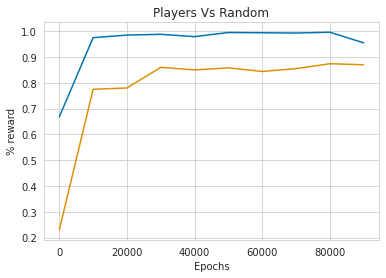

In [21]:
DQN = TicTacToeDQN(3, 3, 3, Network_3x3)
hist_1, hist_2 = DQN_train(DQN, 10000, 1000)

plot_results (hist_1, hist_2)

In [22]:
class Network_4x4(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.c1 = nn.Conv2d(3, 16, (3, 3))
        self.c2 = nn.Conv2d(16, 256, (2, 2))
        self.l1 = nn.Linear(256, 128)
        self.l2 = nn.Linear(128, 16)

    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

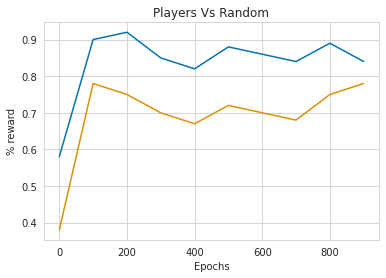

In [23]:
DQN = TicTacToeDQN(4, 4, 4, Network_4x4)
hist_1, hist_2 = DQN_train(DQN, 10000, 1000)
plot_results (hist_1, hist_2)

4. Реализуйте Double DQN и/или Dueling DQN.

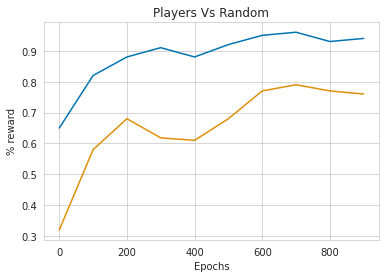

In [24]:
DDQN = TicTacToeDoubleDQN(3, 3, 3, Network_3x3)
hist_1, hist_2= DQN_train(DDQN, 10000, 1000)
plot_results (hist_1, hist_2)

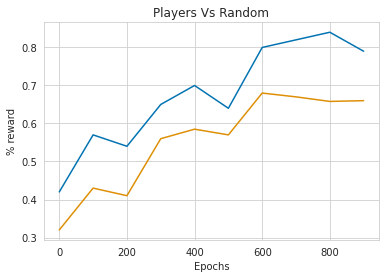

In [25]:
DDQN = TicTacToeDoubleDQN(4, 4, 4, Network_4x4)
hist_1, hist_2 = DQN_train(DDQN, 10000, 1000)
plot_results (hist_1, hist_2)

###**Часть третья: расширим и углубим поиск**


Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов.
5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).
6. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.


In [ ]:
def plot_results(hist_1, hist_2, period = 1000):
    plt.figure(figsize=(10, 6))
    plt.plot(hist_1)
    plt.plot(hist_2)
    plt.xlabel(f'{period} ')
    plt.ylabel('% Epochs')

In [ ]:

env = TicTacToe(3, 3, 3)
tree = MCTS(env, player=1, c=1.0)

hist_1 = []

rewards = {-1: 0, 0: 0, 1: 0}
for i in range(50000):
    tree.learn_episode()
    if (i + 1) % 5000 == 0:
        rewards = {-1: 0, 0: 0, 1: 0}
        for _ in range(1000):
            reward, positions = tree.test_game()
            rewards[reward] += 1
        hist_1.append(rewards[1] / 1000)

In [ ]:

env = TicTacToe(3, 3, 3)
tree = MCTS(env, player=-1, c=1.0)

hist_2 = []

for i in tqdm.tqdm(range(50000)):
    tree.learn_episode()
    if (i + 1) % 5000 == 0:
        rewards = {-1: 0, 0: 0, 1: 0}
        for _ in range(1000):
            reward, positions = tree.test_game()
            rewards[reward] += 1
        hist_2.append(rewards[-1] / 1000)

##Значительный прирост по точности и времени выполнения кода по сравнению с моделью Q-обучение и DQN.

MSCT - 41 sec.




QL - 2 min, не дообучились, мало итераций было



DQN - 14min, но понадобилось больше итераций чтоб решение стало сходиться

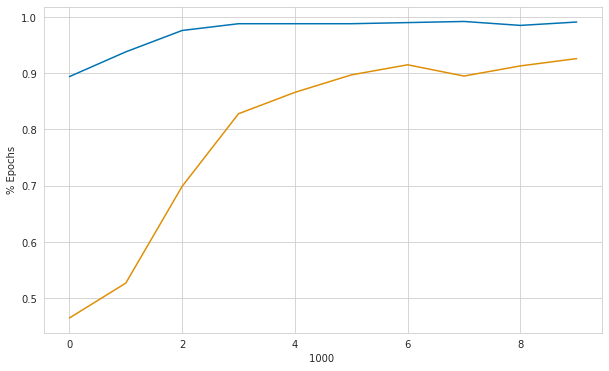

In [43]:
plot_results (hist_1, hist_2)

In [ ]:
env = TicTacToe(4, 4, 4)
tree = MCTS(env, player=1, c=1.0)

hist_1 = []
rewards = {-1: 0, 0: 0, 1: 0}
for i in tqdm.tqdm(range(50000)):
    tree.learn_episode()
    if (i + 1) % 5000 == 0:
        rewards = {-1: 0, 0: 0, 1: 0}
        for _ in range(1000):
            reward, positions = tree.test_game()
            rewards[reward] += 1
        hist_1.append(rewards[1] / 1000)

In [ ]:
env = TicTacToe(4, 4, 4)
tree = MCTS(env, player=-1, c=1.0)

hist_2 = []

for i in tqdm.tqdm(range(50000)):
    tree.learn_episode()
    if (i + 1) % 5000 == 0:
        rewards = {-1: 0, 0: 0, 1: 0}
        for _ in range(1000):
            reward, positions = tree.test_game()
            rewards[reward] += 1
        hist_2.append(rewards[-1] / 1000)

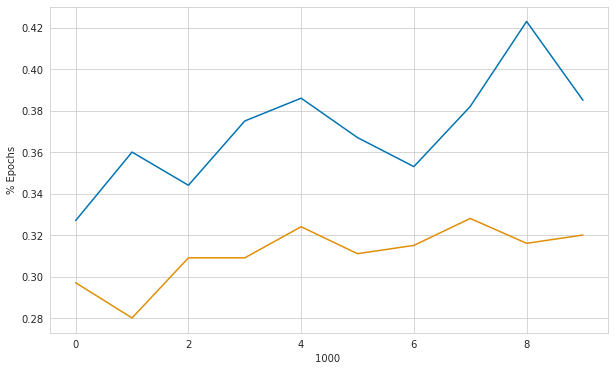

In [47]:
plot_results (hist_1, hist_2)
# надо больше итераций, оринетирвочное время 2 часа)